In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap
import seaborn as sns

In [26]:
# Función para cargar datos desde un archivo CSV o Excel
def cargar_datos(ruta_archivo):
    """
    Carga datos de registros de pozo desde un archivo CSV o Excel.
    
    Args:
        ruta_archivo (str): Ruta al archivo que contiene los datos.
        
    Returns:
        pandas.DataFrame: DataFrame con los datos de registros.
    """
    if ruta_archivo.endswith('.csv'):
        df = pd.read_csv(ruta_archivo, sep=",")
        df.dropna(how='all', inplace=True)
    elif ruta_archivo.endswith(('.xlsx', '.xls')):
        df = pd.read_excel(ruta_archivo)
    else:
        raise ValueError("Formato de archivo no soportado. Use CSV o Excel.")
    
    print(f"Columnas disponibles: {df.columns.tolist()}")
    return df

In [53]:
# Función para calcular volumen de arcilla con el método de rayos gamma
def calcular_vsh_gr(df, gr_columna, gr_min=None, gr_max=None):
    """
    Calcula el volumen de arcilla usando el método de rayos gamma.
    
    Args:
        df (pandas.DataFrame): DataFrame con los datos de registros.
        gr_columna (str): Nombre de la columna que contiene el registro GR.
        gr_min (float, optional): Valor mínimo de GR (arena limpia). Si es None, se calcula del percentil 5.
        gr_max (float, optional): Valor máximo de GR (arcilla). Si es None, se calcula del percentil 95.
        
    Returns:
        pandas.Series: Serie con los valores de volumen de arcilla calculados.
    """
    # Si no se proporcionan valores, calcular automáticamente
    if gr_min is None:
        gr_min = df[gr_columna].quantile(0.05)
    if gr_max is None:
        gr_max = df[gr_columna].quantile(0.95)
    
    print(f"GR min (arena limpia): {gr_min:.2f}")
    print(f"GR max (arcilla): {gr_max:.2f}")
    
    # Índice de rayos gamma lineal
    igr = (df[gr_columna] - gr_min) / (gr_max - gr_min)
    igr = igr.clip(0, 1)  # Restringir valores entre 0 y 1
    
    # Calcular Vsh con diferentes ecuaciones
    vsh_linear = igr.copy()
    
    # Ecuación de Larionov para rocas terciarias
    #vsh_larionov_ter = 0.083 * (2**(3.7 * igr) - 1)
    
    # Ecuación de Larionov para rocas más antiguas
    #vsh_larionov_old = 0.33 * (2**(2 * igr) - 1)
    
    # Ecuación de Clavier
    vsh_clavier = 1.7 - np.sqrt(3.38 - (igr + 0.7)**2)
    
    # Ecuación de Steiber
    #vsh_steiber = igr / (3 - 2 * igr)
    
    # Crear un DataFrame con todos los resultados
    results = pd.DataFrame({
        'VSH_Linear': vsh_linear,
        #'VSH_Larionov_Terciario': vsh_larionov_ter,
        #'VSH_Larionov_Antiguo': vsh_larionov_old,
        'VSH_Clavier': vsh_clavier,
        #'VSH_Steiber': vsh_steiber
    })
    
    return results

In [54]:
# Función para calcular volumen de arcilla con el método de resistividad
def calcular_vsh_res(df, res_columna, res_arena=None, res_arcilla=None):
    """
    Calcula el volumen de arcilla usando el método de resistividad.
    
    Args:
        df (pandas.DataFrame): DataFrame con los datos de registros.
        res_columna (str): Nombre de la columna que contiene el registro de resistividad somera.
        res_arena (float, optional): Valor de resistividad para arena limpia. Si es None, se calcula del percentil 95.
        res_arcilla (float, optional): Valor de resistividad para arcilla. Si es None, se calcula del percentil 5.
        
    Returns:
        pandas.Series: Serie con los valores de volumen de arcilla calculados.
    """
    # Si no se proporcionan valores, calcular automáticamente
    if res_arena is None:
        res_arena = df[res_columna].quantile(0.95)
    if res_arcilla is None:
        res_arcilla = df[res_columna].quantile(0.05)
    
    print(f"Resistividad de arena limpia: {res_arena:.2f} ohm-m")
    print(f"Resistividad de arcilla: {res_arcilla:.2f} ohm-m")
    
    # Modelo de Simandoux simplificado (Resistivity Index Method)
    # Vsh = (log(Rt) - log(Rsand)) / (log(Rshale) - log(Rsand))
    rt = df[res_columna]
    
    # Evitar valores negativos o cero en resistividad
    rt = rt.clip(lower=0.0001)
    
    # Calcular Vsh usando logaritmos
    log_rt = np.log10(rt)
    log_res_arena = np.log10(res_arena)
    log_res_arcilla = np.log10(res_arcilla)
    
    vsh_res = (log_rt - log_res_arena) / (log_res_arcilla - log_res_arena)
    
    # La fórmula arriba da valores altos para arenas y bajos para arcillas, hay que invertir
    #vsh_res = 1 - vsh_res
    
    # Limitar los valores entre 0 y 1
    vsh_res = vsh_res.clip(0, 1)
    
    return vsh_res

In [55]:
# Función para calcular volumen de arcilla con el método de neutrón-densidad
def calcular_vsh_nd(df, nphi_columna, rhob_columna, nphi_matriz=0, rhob_matriz=2.65, 
                   nphi_arcilla=0.45, rhob_arcilla=2.45):
    """
    Calcula el volumen de arcilla usando el método de neutrón-densidad.
    
    Args:
        df (pandas.DataFrame): DataFrame con los datos de registros.
        nphi_columna (str): Nombre de la columna que contiene el registro de neutrón.
        rhob_columna (str): Nombre de la columna que contiene el registro de densidad.
        nphi_matriz (float): Valor de porosidad de neutrón para la matriz.
        rhob_matriz (float): Valor de densidad para la matriz.
        nphi_arcilla (float): Valor de porosidad de neutrón para la arcilla.
        rhob_arcilla (float): Valor de densidad para la arcilla.
        
    Returns:
        pandas.Series: Serie con los valores de volumen de arcilla calculados.
    """
    # Calcular el volumen de arcilla
    numerador = (df[nphi_columna] - nphi_matriz) - (rhob_matriz - df[rhob_columna]) * ((nphi_matriz - nphi_arcilla) / (rhob_matriz - rhob_arcilla))
    denominador = nphi_arcilla - nphi_matriz - (rhob_matriz - rhob_arcilla) * ((nphi_matriz - nphi_arcilla) / (rhob_matriz - rhob_arcilla))
    
    vsh_nd = numerador / denominador
    vsh_nd = vsh_nd.clip(0, 1)  # Restringir valores entre 0 y 1
    
    return vsh_nd

In [56]:
# Función para visualizar los resultados
def visualizar_resultados(df, profundidad_col, vsh_dict, sp_col=None, titulo="Análisis de Arcillosidad"):
    """
    Visualiza los resultados del análisis de arcillosidad.
    
    Args:
        df (pandas.DataFrame): DataFrame con los datos de registros.
        profundidad_col (str): Nombre de la columna que contiene la profundidad.
        vsh_dict (dict): Diccionario con los métodos de cálculo de Vsh y sus resultados.
        sp_col (str, optional): Nombre de la columna que contiene el potencial espontáneo.
        titulo (str): Título del gráfico.
    """
    # Configurar el gráfico
    plt.figure(figsize=(18, 10))
    
    # Definir la distribución de los gráficos
    if sp_col is not None:
        gs = gridspec.GridSpec(1, 3, width_ratios=[3, 1, 1])
    else:
        gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
    
    # Gráfico de registros de arcillosidad
    ax1 = plt.subplot(gs[0])
    depth = df[profundidad_col]
    
    for method_name, vsh_values in vsh_dict.items():
        ax1.plot(vsh_values, depth, label=method_name)
    
    ax1.set_ylim(depth.max(), depth.min())
    ax1.set_xlim(0, 1)
    ax1.set_xlabel('Volumen de Arcilla (V/V)')
    ax1.set_ylabel(f'Profundidad ({profundidad_col})')
    ax1.grid(True)
    ax1.legend()
    
    # Litología simplificada
    ax2 = plt.subplot(gs[1], sharey=ax1)  # Compartir eje Y con el primer gráfico
    
    # Usar el método promedio para la litología
    vsh_promedio = pd.concat(vsh_dict.values(), axis=1).mean(axis=1)
    
    # Asignar colores para la visualización
    colores = []
    for vsh in vsh_promedio:
        if vsh < 0.1:
            colores.append('#ffff00')  # Amarillo - Arena limpia
        elif vsh < 0.3:
            colores.append('#ffcc00')  # Naranja claro - Arena arcillosa
        elif vsh < 0.5:
            colores.append('#cc9900')  # Naranja oscuro - Arena muy arcillosa
        else:
            colores.append('#996633')  # Marrón - Arcilla
    
    # Crear el gráfico de litología como una serie de barras horizontales
    # Un punto por cada profundidad
    litologia_df = pd.DataFrame({
        'Prof': depth,
        'VSH': vsh_promedio,
        'Color': colores
    })
    
    # Ordenar por profundidad para asegurar la visualización correcta
    litologia_df = litologia_df.sort_values('Prof')
    
    # Calcular el paso de profundidad (delta)
    if len(depth) > 1:
        # Encontrar el paso de profundidad más común
        depth_sorted = sorted(depth)
        deltas = [depth_sorted[i+1] - depth_sorted[i] for i in range(len(depth_sorted)-1)]
        if deltas:
            delta = np.median(deltas)
        else:
            delta = 1.0
    else:
        delta = 1.0
    
    # Graficar cada punto como una barra horizontal
    for i, row in litologia_df.iterrows():
        ax2.barh(row['Prof'], 1, height=delta, color=row['Color'], 
                 edgecolor='none', align='center')
    
    # Configurar el eje X
    ax2.set_xlim(0, 1)
    ax2.set_xlabel('Litología')
    ax2.set_xticks([])
    
    # Leyenda para la litología
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#ffff00', label='Arena limpia (Vsh < 0.1)'),
        Patch(facecolor='#ffcc00', label='Arena arcillosa (0.1 ≤ Vsh < 0.3)'),
        Patch(facecolor='#cc9900', label='Arena muy arcillosa (0.3 ≤ Vsh < 0.5)'),
        Patch(facecolor='#996633', label='Arcilla (Vsh ≥ 0.5)')
    ]
    ax2.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.15))
    
    # Si se proporciona la columna de SP, agregar el gráfico de potencial espontáneo
    if sp_col is not None:
        ax3 = plt.subplot(gs[2], sharey=ax1)  # Compartir eje Y con el primer gráfico
        
        # Si existe la columna de SP en el dataframe, usar esos datos
        if sp_col in df.columns:
            sp_values = df[sp_col]
            ax3.plot(sp_values, depth, 'g-', linewidth=1.5)
        else:
            # Generar valores esquemáticos de SP basados en la litología
            # Arenas limpias: SP negativo (deflexión izquierda), Arcillas: SP cercano a cero (línea base)
            sp_values = []
            for vsh in vsh_promedio:
                if vsh < 0.1:  # Arena limpia
                    sp_values.append(-70 + np.random.normal(0, 5))
                elif vsh < 0.3:  # Arena arcillosa
                    sp_values.append(-50 + np.random.normal(0, 10))
                elif vsh < 0.5:  # Arena muy arcillosa
                    sp_values.append(-30 + np.random.normal(0, 10))
                else:  # Arcilla
                    sp_values.append(0 + np.random.normal(0, 5))
            
            # Suavizar los valores de SP para hacer una curva más realista
            window_size = 5
            if len(sp_values) > window_size:
                sp_values = np.convolve(sp_values, np.ones(window_size)/window_size, mode='same')
            
            ax3.plot(sp_values, depth, 'g-', linewidth=1.5)
        
        # Configurar el eje SP
        ax3.set_xlim(-80, 20)
        ax3.set_xlabel('SP (mV)')
        ax3.grid(True)
        
        # Agregar línea vertical en SP=0 (línea base de arcilla)
        ax3.axvline(x=0, color='k', linestyle='--', alpha=0.5)
        
        # Agregar línea de arena (línea estática de SP)
        ax3.axvline(x=-70, color='b', linestyle='--', alpha=0.3)
    
    plt.suptitle(titulo, fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    
    return plt

In [57]:
# Función principal para ejecutar el análisis completo
def analisis_arcillosidad(ruta_archivo, prof_col, gr_col=None, nphi_col=None, rhob_col=None, 
                          res_col=None, gr_min=None, gr_max=None, sp_col=None, 
                          res_arena=None, res_arcilla=None,
                          usar_gr=True, usar_nd=False, usar_res=True):
    """
    Realiza un análisis completo de arcillosidad utilizando diferentes métodos.
    
    Args:
        ruta_archivo (str): Ruta al archivo de datos.
        prof_col (str): Columna de profundidad.
        gr_col (str, optional): Columna de rayos gamma.
        nphi_col (str, optional): Columna de porosidad neutrón.
        rhob_col (str, optional): Columna de densidad.
        res_col (str, optional): Columna de resistividad somera.
        gr_min (float, optional): Valor mínimo de GR para arena limpia.
        gr_max (float, optional): Valor máximo de GR para arcilla.
        sp_col (str, optional): Columna de potencial espontáneo.
        res_arena (float, optional): Valor de resistividad para arena limpia.
        res_arcilla (float, optional): Valor de resistividad para arcilla.
        usar_gr (bool): Si se debe usar el método de rayos gamma.
        usar_nd (bool): Si se debe usar el método de neutrón-densidad.
        usar_res (bool): Si se debe usar el método de resistividad.
        
    Returns:
        pandas.DataFrame: DataFrame con todos los resultados calculados.
    """
    # Cargar los datos
    df = cargar_datos(ruta_archivo)
    
    # Diccionario para almacenar los resultados
    vsh_results = {}
    
    # Calcular Vsh con método de rayos gamma
    if usar_gr and gr_col and gr_col in df.columns:
        print("\nCálculo de Vsh con método de rayos gamma:")
        vsh_gr_df = calcular_vsh_gr(df, gr_col, gr_min, gr_max)
        
        # Agregar resultados al diccionario
        for col in vsh_gr_df.columns:
            vsh_results[col] = vsh_gr_df[col]
    
    # Calcular Vsh con método de neutrón-densidad
    if usar_nd and nphi_col and rhob_col and nphi_col in df.columns and rhob_col in df.columns:
        print("\nCálculo de Vsh con método de neutrón-densidad:")
        vsh_nd = calcular_vsh_nd(df, nphi_col, rhob_col)
        vsh_results['VSH_Neutron_Densidad'] = vsh_nd
    
    # Calcular Vsh con método de resistividad
    if usar_res and res_col and res_col in df.columns:
        print("\nCálculo de Vsh con método de resistividad:")
        vsh_res = calcular_vsh_res(df, res_col, res_arena, res_arcilla)
        vsh_results['VSH_Resistividad'] = vsh_res
    
    # Verificar si hay resultados
    if not vsh_results:
        raise ValueError("No se pudo calcular Vsh con ningún método. Verifique los nombres de las columnas.")
    
    # Combinar resultados en un DataFrame
    results_df = pd.DataFrame(vsh_results)
    
    # Calcular el promedio de todos los métodos
    results_df['VSH_Promedio'] = results_df.mean(axis=1)
    
    # Agregar los resultados al DataFrame original
    df_resultado = pd.concat([df, results_df], axis=1)
    
    # Visualizar resultados
    plt = visualizar_resultados(df, prof_col, vsh_results, sp_col)
    plt.show()
    
    return df_resultado

Columnas disponibles: ['DEPTH', 'GR', 'SP', 'RES', 'zonas']

Cálculo de Vsh con método de rayos gamma:
GR min (arena limpia): 75.64
GR max (arcilla): 92.17

Cálculo de Vsh con método de resistividad:
Resistividad de arena limpia: 8.85 ohm-m
Resistividad de arcilla: 1.62 ohm-m


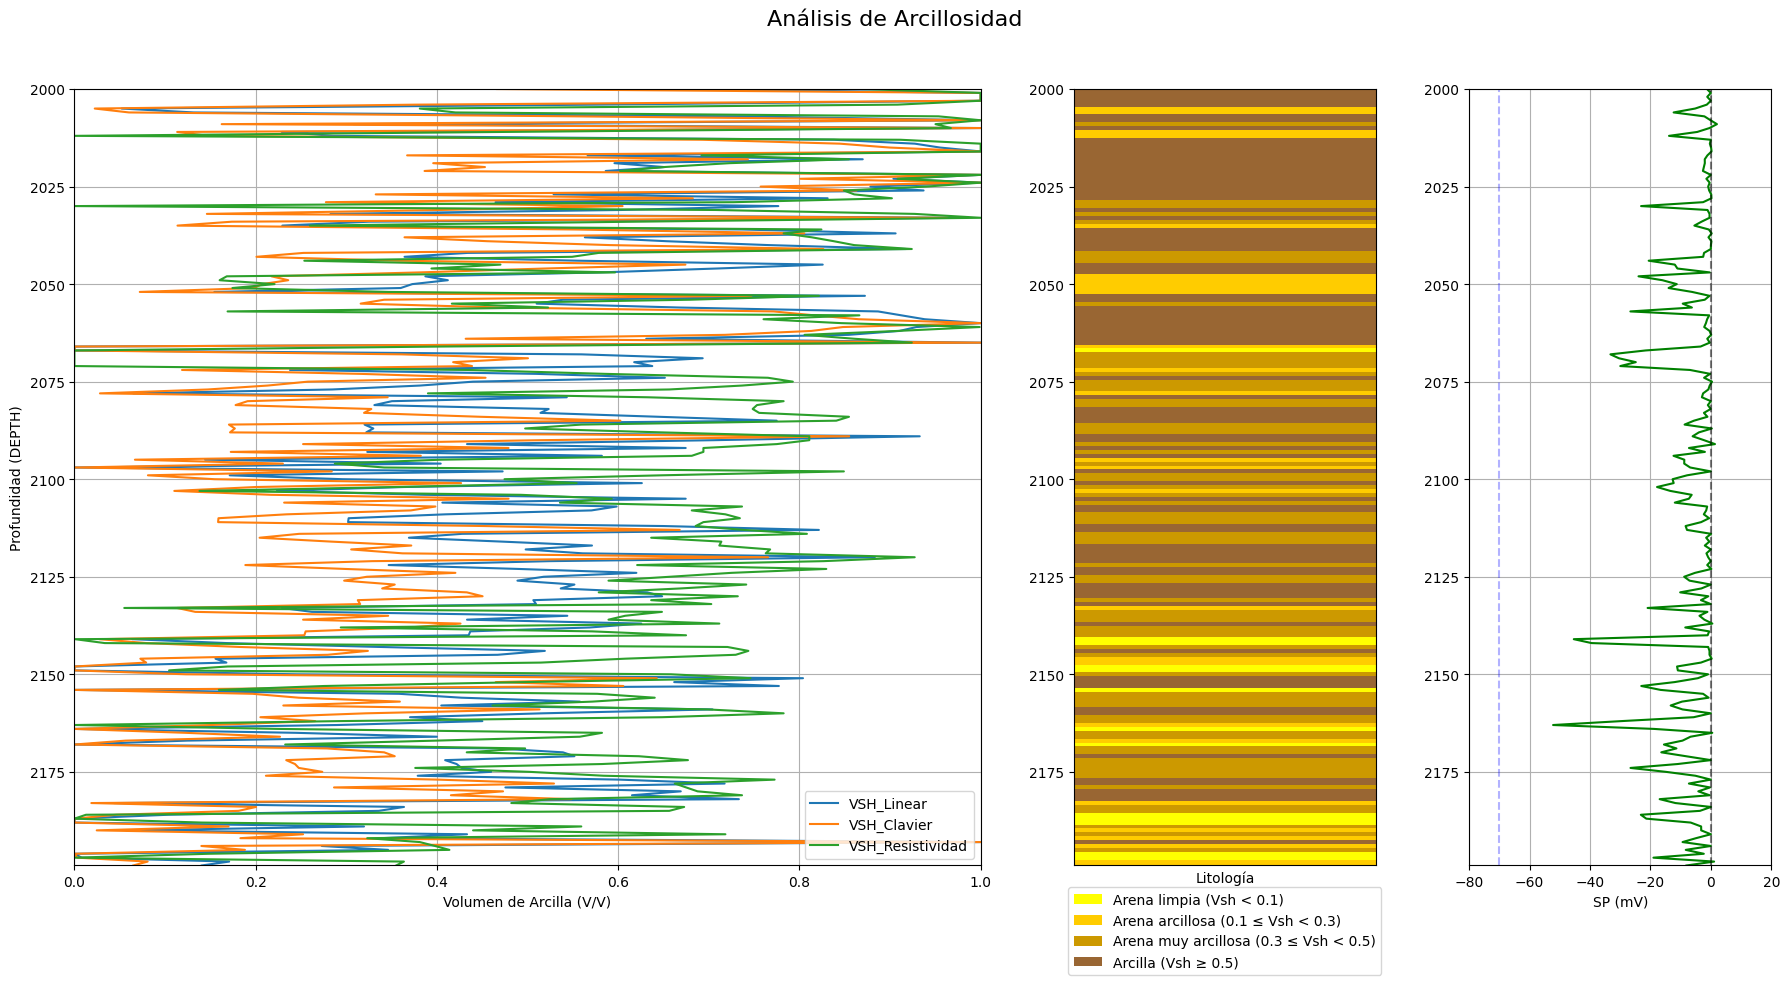

Análisis completado. Resultados guardados en 'resultados_arcillosidad.csv'


In [58]:
# Ejemplo de uso
if __name__ == "__main__":
    # Ejemplo con datos ficticios
    # En un caso real, reemplaza estos valores con tu archivo y nombres de columnas
    resultados = analisis_arcillosidad(
        ruta_archivo="prueba.csv",  # Reemplazar con la ruta real
        prof_col="DEPTH",
        gr_col="GR",
        nphi_col="NPHI",
        rhob_col="RHOB",
        res_col="RES",     # Columna de resistividad somera
        sp_col="SP",      # Columna de SP
        gr_min=None,        # Opcional, valor mínimo de GR (arena limpia)
        gr_max=None,       # Opcional, valor máximo de GR (arcilla)
        res_arena=None,    # Opcional, resistividad típica de arena limpia (ohm-m)
        res_arcilla=None     # Opcional, resistividad típica de arcilla (ohm-m)
    )
    
    # Guardar resultados
    resultados.to_csv("resultados_arcillosidad.csv", index=False)
    print("Análisis completado. Resultados guardados en 'resultados_arcillosidad.csv'")